## __A/B testing in product management:  Frequentist approach vs a bayesian approach__

__Learning Objectives:__ I see new topics as gateways to better questions. Yes, nowadays we have AI and wonderful software but they are as good as the questions you throw at them. Even if you dont have enough statistical expertise to get bayesian statistics or causal inference, I think it is worth at least knowing about this approach, because otherwise, you might make you company __lose money__.

__Also, this is not a post about some statistical tools. This is about BUSINESS. It doesnt matter whether one is better or not. We do care about making an impact.__

A/B testing, or known as randomized control trials are used very much in industry, specially in marketing and product settings.
Many companies want to know the effect of doing certain actions and if they are effective or not. In the following example, I want to explore th difference between the frequentists approach and the bayesian approach.

__Frequentist A/B testing__  refers to the every_day A/B testing, the one someone with a non data science background would be familiar. 
However, it has shortcommings. How do you add prior knowledge in your test? What if my test is not "statistically significant" or what if p value is not less thatn 0.05?

__The bayesian approach__, is the one approach that solves the frequentist approach shortcommings. In addition to the advantages of the frequentist approach, it allows you to incorporate prior knowledge, making your results more trustworthy. Also, you can anwser the questions of statistically significance with no problem. The only side problem is that the bayesian approach is computationally more expensive. 


## First things first: Data generation
To appreciate the difference between both approaches, Im gonna generate some synthtic data, in such a way that we will know the __ground truth__ of it. So we can better appreciate the differences between approaches

__Business setting__: Suppose you are a product manager in a fast growth tech company and you are trying to figure out weather a new feature in the signup phase will actually improve the number of daily active users. You run a randomized control trial, meaning an experiment (A/B test) giving the feature to a part of the population randomly while the rest of the population stays the same 

__Hypothesis__: The new feature will improve DAU metric.

__Considerations__:


-You run a experiment for 30 days and get DAU for a whole month.

-There company has been adding on average 10 DAU everyday so, time needs to be controlled in order to avoid confounding bias.

-The ground truth of the experiment will be that the features actually improve by 50 DAUs per month.

-The feature we are testing is low stakes. Meaning that changing it will not take very long

-Lets suppose that for every additional DAU per month, the company projects to make $1000 per year, so this is $50k stakes experiment. Basically it could pay someone's anual salary.

-There is a catch. The data you get from the new feature is actually more volatile, which is very likely in real life scenarios. This will test the __limits of Product managers with surface-level analytics exposure.__





In [ ]:
import numpy as np
import pymc as pm
import statsmodels.formula.api as smf
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

warnings.filterwarnings("ignore")

In [45]:
#simulate data 

def data_generation():
    days_per_group=30


    time=np.arange(1,days_per_group+1,1)


    no_feature=np.zeros((days_per_group,1))
    new_feature=np.ones((days_per_group,1))

    DAU_no_feature=np.random.normal(1000,100,days_per_group)+10*time+np.random.normal(100,20,days_per_group)
    DAU_feature=np.random.normal(1050,150,days_per_group)+10*time+np.random.normal(100,20,days_per_group)


    data_no_feature=np.column_stack((time,DAU_no_feature,no_feature))
    data_feature=np.column_stack((time,DAU_feature,new_feature))

    data=np.concatenate((data_no_feature,data_feature))
    data=pd.DataFrame(data)

    data=data.rename(columns={0:'time',1:'DAU',2:"feature"})
    return data

data=data_generation()


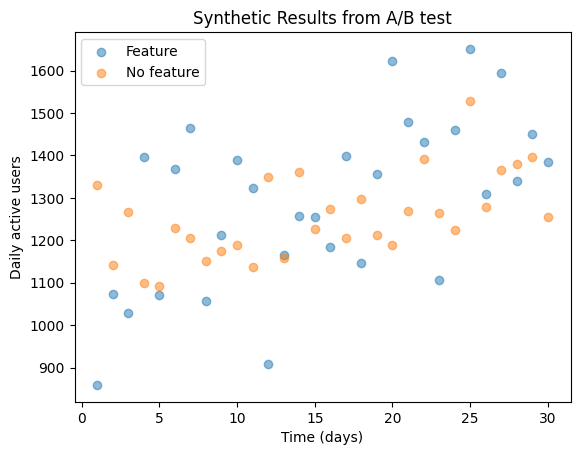

In [52]:
plt.scatter(data['time'][data['feature']==1], data['DAU'][data['feature']==1], label='Feature', alpha=0.5)
plt.scatter(data['time'][data['feature']==0], data['DAU'][data['feature']==0], label='No feature', alpha=0.5)
plt.title('Synthetic Results from A/B test')
plt.xlabel('Time (days)')
plt.ylabel('Daily active users')
plt.legend()
plt.show()

## Traditional A/B testing

In [46]:
model=smf.ols('DAU~C(feature)+time',data).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DAU   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     12.26
Date:                Thu, 22 May 2025   Prob (F-statistic):           3.74e-05
Time:                        23:52:08   Log-Likelihood:                -377.82
No. Observations:                  60   AIC:                             761.6
Df Residuals:                      57   BIC:                             767.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1103.9552     39.705     27.804      0.000    1024.448    1183.462
C(feature)[T.1.0]    36.7458     34.800      1.056      0.295     -32.941     106.432
time                  9.7243      2.010      4.837      0.000       5.699      13.750
==============================================================================
Omnibus:                        0.330   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.848   Jarque-Bera (JB):                0.030
Skew:                           0.018   Prob(JB):                        0.985
Kurtosis:                       3.104   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Recap:__

As a result we can see that the traditional approach has an low fit to the data, but what we really care is about the variables and weather they are significant:
So, intercept and time are statistically significant (p_values < 0.05)
But, the effect of the new feature, although positive, is not statistically significant.

 So, in this case, you might either: gather more data for another month, discard the feature, use bayesian statistics.

 Let's go for the latter one


## Bayesian A/B testing

Now we are going to use bayesian A/B testing. The magic of this approach is the following:

1) We can set up prior knowledge which is:

     -DAUs have been growing organically at a pace of 10 DAUs per day, and there is no reason to think that this should have changed during the month we performed the experiment. We will give some flexibility to the model but we are saying that DAUs do grow over time

     -We somewhat know the base DAUs for this case but we will give the model flexibility to come up with it.

     -There is noise(vlatility) in the DAUs.

2) We get full posterior distributions. This means that we get the full range of possible values and not only point estimates like above.


In [ ]:
#pymc

with pm.Model() as model:

    # Priors
    intercept = pm.Normal('intercept', mu=1100, sigma=200)
    effect_feature = pm.Normal('effect_feature', mu=0, sigma=100,shape=2)
    effect_time=pm.TruncatedNormal('effect_time',mu=5,sigma=5,lower=0,upper=100)

    # Noise
    sigma = pm.HalfNormal('sigma', sigma=200)
    
    mu = (
    intercept 
    + effect_feature[data['feature'].values.astype(int)] 
    + effect_time*data['time'].values.astype(int)
)
    
    # Likelihood
    dau = pm.Normal('DAU', mu=mu, sigma=sigma, observed=data['DAU'].values)

    # Treatment effect
    delta = pm.Deterministic("delta", effect_feature[1] - effect_feature[0])
    
    trace = pm.sample(1000, tune=500, chains=2, cores=12, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, effect_feature, effect_time, sigma]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [28]:
az.summary(trace, var_names=["intercept", "delta",'effect_time' ,"sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1144.445,73.577,1008.151,1283.873,2.645,1.962,774.0,791.0,1.0
delta,45.374,33.933,-15.147,112.261,0.707,0.863,2322.0,1319.0,1.0
effect_time,8.735,1.836,5.482,12.281,0.055,0.047,1127.0,758.0,1.0
sigma,135.471,13.110,113.413,161.679,0.396,0.344,1136.0,946.0,1.0


array([[<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'effect_time'}>,
        <Axes: title={'center': 'effect_time'}>],
       [<Axes: title={'center': 'effect_feature'}>,
        <Axes: title={'center': 'effect_feature'}>]], dtype=object)

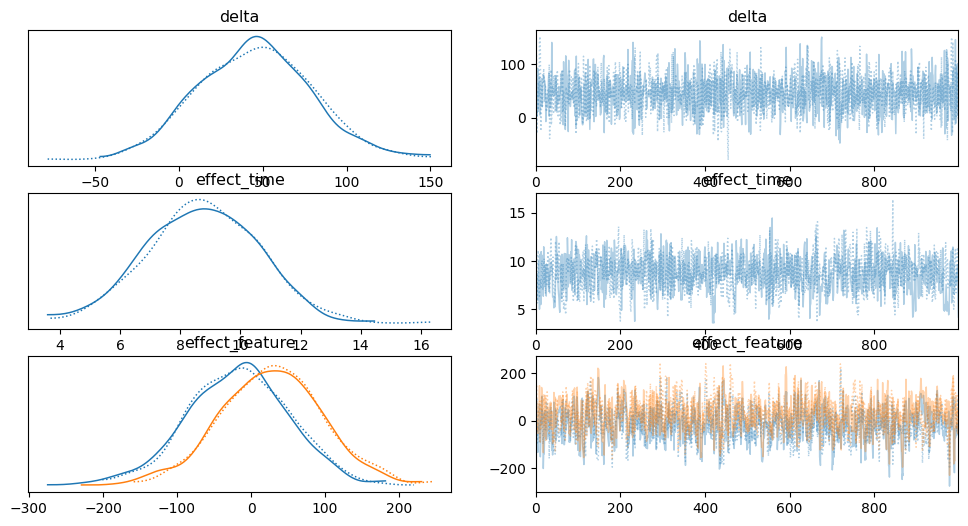

In [47]:
az.plot_trace(trace, var_names=[ "delta",'effect_time','effect_feature'])


In [48]:
delta_samples = trace.posterior["delta"].values.flatten()

# Estimate probability that delta > 0
p_positive = np.mean(delta_samples > 0)

print(f"Posterior P(delta > 0): {p_positive:.3f}")

Posterior P(delta > 0): 0.907


__Recap:__

We have estimated the range of possible values of the actual effect.
Overall, they all look similar. 

__However__ we see that the mean value is actually closer to the true value using this approach. Not only that, but we can calculate with certainty how proable is that the effect of a new variable is possible. And that is 90%.

Based on the posterior distribution, there is a high probability that the feature has a positive effect on DAU. While the exact magnitude remains uncertain, the Bayesian analysis suggests that enabling the feature is likely to improve performance



## Lessons learned

I used a Bayesian model to estimate the effect of the feature on DAU, controlling for time. The posterior shows a high probability that the feature improves performance, but the credible interval still includes zero — meaning there's still some uncertainty.

This isn’t just about p-values. Bayesian modeling gives you the actual probability the effect is real, not just whether it crosses some arbitrary threshold like the p-value. That makes it better suited for decisions where mistakes cost money.

__My reccomendation__: go ahead with the feature because (1) There is a 90% probability of being a positive effect. Most business decisions __would love__ to have a 90% of certainty. Also, (2) the cost of rolling such a feature is minimal.

__I think it is important to notice that if we were statistical purists, we would have stopped after our first regression and declared that it was not statistically signifcant and therefore not to roll the change. This, potentially, could have costed the company $50k. That is the lesson Im trying to transmit. On one side, being too technical might blind you from the real business impact. Being too businessy, might not allow you to ask the right questions. Always keep learning :)__
